# Detrended Fluctuation Analysis (DFA)

# Long-Range Correlation

## What Is Long-Range Correlation?

**Long-range correlation** (also called **long-memory** or **long-range dependence**) in a time series means that data points **far apart in time** are still **statistically dependent**. In other words, values from the distant past can still influence current values.

---

## Intuition

Most time series (e.g., noise) exhibit **short-term memory**: recent values affect only the near future.

A **long-range correlated** signal, on the other hand, "remembers" its history across long time spans. This leads to:

- **Slowly decaying correlations**
- **Persistence** in the trend or pattern
- **Fractal or self-similar behavior**

---

## Mathematical Definition

A time series \( x(t) \) has long-range correlations if its autocorrelation function \( C(s) \) decays as a power law:

$$
C(s) \sim s^{-\gamma}, \quad \text{with } 0 < \gamma < 1
$$

- $ s $: lag (distance between time points)
- $ \gamma $: correlation exponent

This slow decay (non-exponential) means distant points are still correlated.

---

## Key Features

- **Persistent behavior**: If the series has been increasing, it’s likely to continue increasing.
- **Fractal structure**: The data shows self-similarity over multiple time scales.
- **No characteristic time scale**: The correlation doesn't vanish quickly with distance.

---

## Real-World Examples

- Heart rate variability in healthy individuals
- Internet or network traffic
- Seismic activity (earthquake series)
- Financial market volatility
- Climate data (e.g., temperature or rainfall)

---

## Why It Matters

Understanding long-range correlations helps:

- Model complex systems more accurately
- Detect hidden memory in seemingly random signals
- Improve predictions and anomaly detection



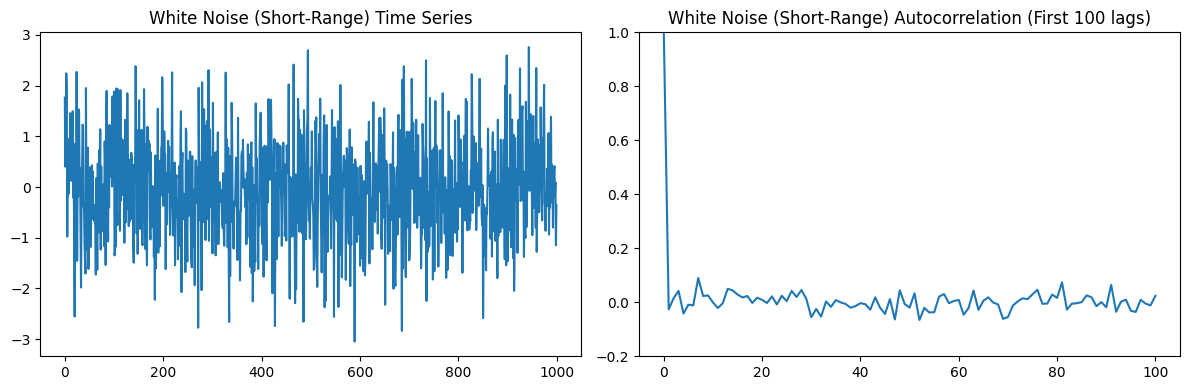

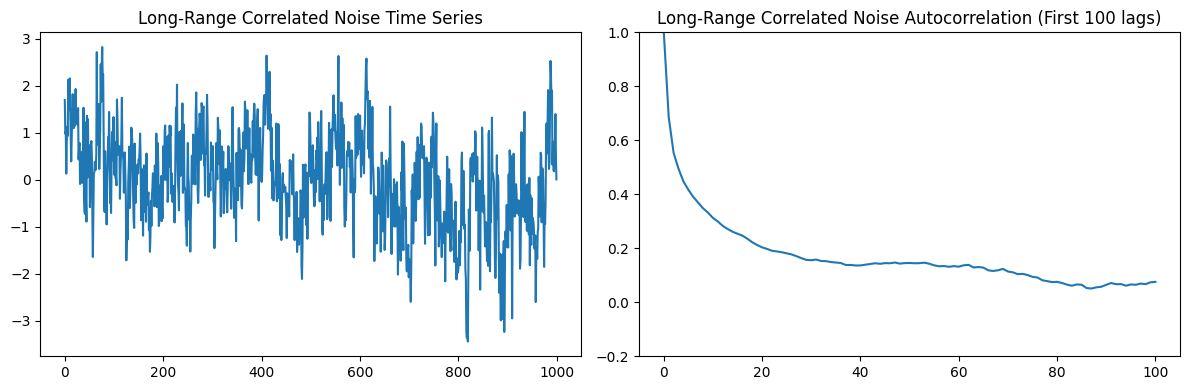

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf

# Function to plot time series and autocorrelation
def plot_series_and_acf(series, title):
    lags = 100
    acf_vals = acf(series, nlags=lags)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(series)
    axs[0].set_title(f'{title} Time Series')
    axs[1].plot(acf_vals)
    axs[1].set_title(f'{title} Autocorrelation (First {lags} lags)')
    axs[1].set_ylim([-0.2, 1.0])
    plt.tight_layout()
    plt.show()

# 1. Short-range correlation: White Noise
np.random.seed(0)
white_noise = np.random.normal(size=1000)
plot_series_and_acf(white_noise, "White Noise (Short-Range)")

# 2. Long-range correlation: Fractional Gaussian Noise (using power-law filtered noise)
def generate_long_range_noise(N, alpha=0.7):
    # alpha close to 1 gives stronger long-range correlations
    freqs = np.fft.rfftfreq(N)
    freqs[0] = 1e-10  # avoid divide-by-zero
    power_law = freqs ** (-alpha / 2.0)
    random_phases = np.exp(2j * np.pi * np.random.rand(len(freqs)))
    spectrum = power_law * random_phases
    time_series = np.fft.irfft(spectrum)
    return (time_series - np.mean(time_series)) / np.std(time_series)

long_range_series = generate_long_range_noise(1000, alpha=0.9)
plot_series_and_acf(long_range_series, "Long-Range Correlated Noise")


# Detrended Fluctuation Analysis (DFA)

## Overview

**Detrended Fluctuation Analysis (DFA)** is a statistical method used to detect long-range correlations and scaling behavior in time series data, especially when the data are **non-stationary** (i.e., their statistical properties vary over time).

**Applications**: DFA is widely used in physiology (e.g., heart rate variability), finance, climate research, neuroscience, and other fields dealing with complex temporal patterns.

---

## DFA Procedure

1. **Integration**  
   Given a time series $x(i)$, compute its cumulative sum (i.e., "profile"):

   $$
   Y(k) = \sum_{i=1}^{k} [x(i) - \bar{x}]
   $$

   where $\bar{x}$ is the mean of the original series.

2. **Division into Segments**  
   Divide the profile $Y(k)$ into non-overlapping segments of equal length $n$.

3. **Detrending**  
   In each segment, fit a polynomial trend (often linear) $Y_{\text{fit}}(k)$ and subtract it from the profile:

   $$
   \text{Residual}(k) = Y(k) - Y_{\text{fit}}(k)
   $$

4. **Calculate Fluctuations**  
   Compute the root-mean-square (RMS) fluctuation for all segments:

   $$
   F(n) = \sqrt{\frac{1}{N} \sum_{k=1}^{N} [Y(k) - Y_{\text{fit}}(k)]^2}
   $$

5. **Scaling Analysis**  
   Repeat the above steps for various segment lengths $n$, and plot $\log F(n)$ versus $\log n$.

   The slope $\alpha$ of this log-log plot reflects the correlation structure:

   - $\alpha = 0.5$: uncorrelated (white noise)
   - $0.5 < \alpha < 1$: long-range correlations
   - $\alpha > 1$: non-stationary, Brownian-like behavior

---

## Why Use DFA?

- DFA is robust against trends and nonstationary components in time series.
- Traditional methods (like autocorrelation or Fourier analysis) may incorrectly identify trends as correlations.
- DFA provides a more accurate assessment of intrinsic fluctuations and scaling behavior.


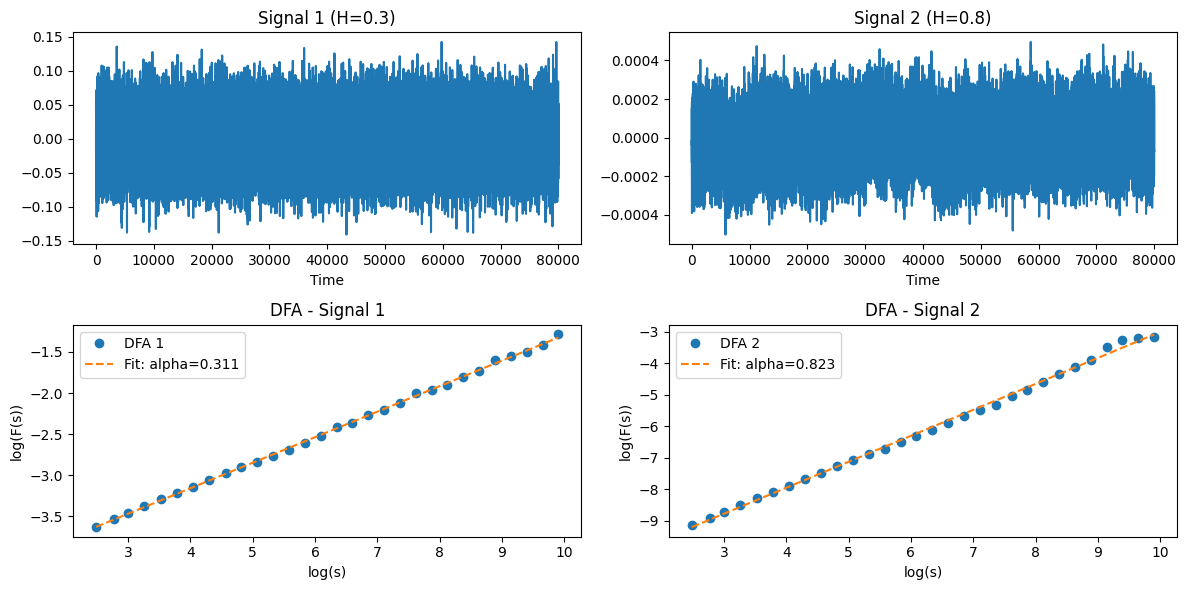

Estimated alpha for H=0.3: 0.311
Estimated alpha for H=0.8: 0.823


In [13]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from fbm import FBM  # pip install fbm

# ----------------------
# DFA DEMO using Accurate fBm Generator
# ----------------------
def generate_fbm_signal(N, H):
    """Generate fractional Brownian motion using the Davies-Harte method"""
    fbm_obj = FBM(n=N-1, hurst=H, length=1.0, method='daviesharte')
    return fbm_obj.fbm()

def detrended_fluctuation_analysis(signal, scales, order=1):
    N = len(signal)
    Y = np.cumsum(signal - np.mean(signal))
    F = []

    for s in scales:
        n_segments = N // s
        local_rms = []

        for i in range(n_segments):
            segment = Y[i*s:(i+1)*s]
            x = np.arange(s)
            coeffs = np.polyfit(x, segment, order)
            trend = np.polyval(coeffs, x)
            rms = np.sqrt(np.mean((segment - trend)**2))
            local_rms.append(rms)

        F.append(np.sqrt(np.mean(np.square(local_rms))))

    return np.array(F)

def plot_dfa_comparison(signal1, signal2, H1=0.3, H2=0.8):
    N = len(signal1)
    scales = np.unique(np.logspace(1.1, np.log10(N/4), num=30, dtype=int))

    F1 = detrended_fluctuation_analysis(signal1, scales)
    F2 = detrended_fluctuation_analysis(signal2, scales)

    log_scales = np.log(scales)
    log_F1 = np.log(F1)
    log_F2 = np.log(F2)

    alpha1, intercept1 = np.polyfit(log_scales, log_F1, 1)
    alpha2, intercept2 = np.polyfit(log_scales, log_F2, 1)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 2, 1)
    plt.plot(signal1)
    plt.title(f"Signal 1 (H={H1})")
    plt.xlabel("Time")

    plt.subplot(2, 2, 2)
    plt.plot(signal2)
    plt.title(f"Signal 2 (H={H2})")
    plt.xlabel("Time")

    plt.subplot(2, 2, 3)
    plt.plot(log_scales, log_F1, 'o', label="DFA 1")
    plt.plot(log_scales, alpha1*log_scales + intercept1, '--', label=f"Fit: alpha={alpha1:.3f}")
    plt.title("DFA - Signal 1")
    plt.xlabel("log(s)")
    plt.ylabel("log(F(s))")
    plt.legend()

    plt.subplot(2, 2, 4)
    plt.plot(log_scales, log_F2, 'o', label="DFA 2")
    plt.plot(log_scales, alpha2*log_scales + intercept2, '--', label=f"Fit: alpha={alpha2:.3f}")
    plt.title("DFA - Signal 2")
    plt.xlabel("log(s)")
    plt.ylabel("log(F(s))")
    plt.legend()

    plt.tight_layout()
    plt.show()

    print(f"Estimated alpha for H={H1}: {alpha1:.3f}")
    print(f"Estimated alpha for H={H2}: {alpha2:.3f}")

# Run DFA comparison with accurate fBm
N = 80000
H1 = 0.3
H2 = 0.8
signal1 = generate_fbm_signal(N, H1)
signal2 = generate_fbm_signal(N, H2)
fGn_signal1 = np.diff(signal1)
fGn_signal2 = np.diff(signal2)

plot_dfa_comparison(fGn_signal1, fGn_signal2, H1, H2)


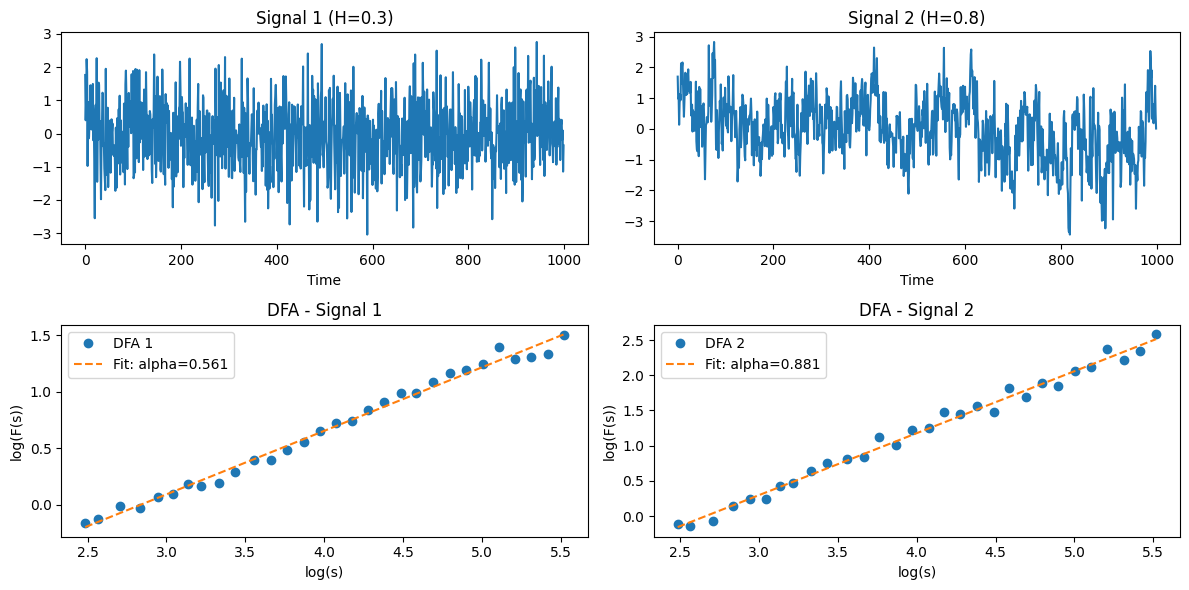

Estimated alpha for H=0.3: 0.561
Estimated alpha for H=0.8: 0.881


In [14]:
plot_dfa_comparison(white_noise, long_range_series, H1, H2)